<a href="https://colab.research.google.com/github/laliali20/dsi_preassignment/blob/main/DSIPreAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

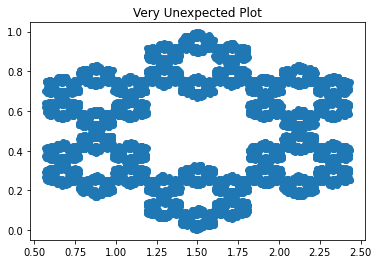

In [1]:
import math
from shapely.geometry.polygon import LinearRing, Polygon
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import rankdata

# function to randomly select point within the hexagon
def random_point(edges):
    x_points_max = [max(val[0][0], val[1][0]) for val in edges]
    x_points_min = [min(val[0][0], val[1][0]) for val in edges]
    y_points_max = [max(val[0][1], val[1][1]) for val in edges]
    y_points_min = [min(val[0][1], val[1][1]) for val in edges]
    x_random = np.random.rand()
    point_x = x_random * (max(x_points_max) - min(x_points_min)) + min(x_points_min) 
    slopes = [(val[0][1] - val[1][1])/(val[0][0] - val[1][0]) for val in edges]
    intercepts  = [val[0][1] - ((val[0][1] - val[1][1])/(val[0][0] - val[1][0])) * val[0][0] for val in edges]
    y_values = np.array(slopes) * point_x + np.array(intercepts)
    consider_edge = np.zeros(len(edges))
    
    for i in range(len(y_values)):
        if y_values[i] <= y_points_max[i] and y_values[i] >= y_points_min[i] and point_x <= x_points_max[i] and point_x >= x_points_min[i]   :
            consider_edge[i] = 1

    y_random = np.random.rand()
    considered_edges  = [i for i, val in enumerate(consider_edge) if (val==1)]
    considered_edges_values = y_values[considered_edges]

    if sum(consider_edge) == 2: 
        y_length = abs(considered_edges_values[0] - considered_edges_values[1])
        point_y = min(considered_edges_values) + y_random * y_length
    elif sum(consider_edge) == 4:
        ranked_ys = rankdata(considered_edges_values)
        interval1_items = [considered_edges_values[i] for i, val in enumerate(ranked_ys) if (val <= 2)]
        interval2_items = [considered_edges_values[i] for i, val in enumerate(ranked_ys) if (val > 2)]
        interval1_len = abs(interval1_items[0] - interval1_items[1])
        interval2_len = abs(interval2_items[0] - interval2_items[1])
        interval = interval1_len + interval2_len
        # interval
        interval1_prob = interval1_len/interval
        if y_random <= interval1_prob:
            point_y = min(interval1_items) + interval * y_random
        else:
            point_y = min(interval2_items) +   (interval * y_random) - interval1_len         
    return [point_x,point_y]

# function to find closest adjacent edge (I  was initially using vertices)
def find_closest_adjacent_verices(random_point, edges): 
    distance = 1000000000
    # distances = []
    closest_edge = []
    for edge in edges:
        midpoint_x = (edge[0][0] + edge[1][0])/2
        midpoint_y = (edge[0][1] + edge[1][1])/2
        temp_distance  = math.sqrt(((midpoint_x - random_point[0]) ** 2)  +  ((midpoint_y - random_point[1]) ** 2))
        
        if temp_distance < distance:
            distance = temp_distance
            closest_edge = edge 
        # distances.append(temp_distance)      
    return closest_edge


# define hexagon vertices and edges
a = 1 - (math.sqrt(3)/2)
b = 2 + (math.sqrt(3)/2)

#### Main Code
# regular hexagon 
hex_veritices = [(a, 0.5), (1, 1), (2, 1), (b, 0.5), (2, 0), (1, 0)]
edges = [[(a, 0.5),(1, 1)], [(a, 0.5),(1, 0)], [(1, 1), (2, 1)], [(1, 0), (2, 0)], [(b, 0.5), (2, 0)], [(b, 0.5), (2, 1)]] 

# irregular hexagon
# hex_veritices = [(1,10), (2,8), (5, 11), (2, 14), (1, 13), (2, 11)]  
# edges = [[(1,10), (2,8)], [(2,8), (5, 11)], [(5, 11), (2, 14)], [(2, 14), (1, 13)], [(1, 13), (2, 11)], [(2, 11), (1,10)]]  

poly = Polygon(hex_veritices)

# make triangles
triangles  = []
random_point_x = []
random_point_y = []
shape = [poly]
random_point = random_point(edges)
for  i in range(0, 10000):
    random_point_x.append(random_point[0])
    random_point_y.append(random_point[1])
    vert = edges[np.random.randint(len(edges))]
    triangles.append([vert[0], vert[1], (random_point[0],random_point[1])])
    shape.append(Polygon([vert[0], vert[1], (random_point[0],random_point[1])]))
    random_point = [(vert[0][0] + vert[1][0] + random_point[0])/3, (vert[0][1] + vert[1][1] + random_point[1])/3]
# fig, axs = plt.subplots()
# fig.set_size_inches(5, 5)
# for poly in shape:    
#     xs, ys = poly.exterior.xy    
#     axs.plot(xs, ys, color='#6699cc' ) 
# plt.title("Hexagon With Triangles plot")
# plt.show()
plt.scatter(random_point_x, random_point_y)
plt.title("Very Unexpected Plot")
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import torch
from torch.autograd import Variable
import math


# import data

df1 = pd.read_csv('title.basics.tsv.gz', sep='\t')
df2 = pd.read_csv('title.akas.tsv.gz', sep='\t')
df3 = pd.read_csv('title.ratings.tsv.gz', sep='\t')

# remove duplicates
duplicates_df = pd.DataFrame([['df1', sum(df1.duplicated())], ['df2', sum(df2.duplicated())], ['df3', sum(df3.duplicated())]], columns=['dataFrame','NumberOfDupilcates'])
print(duplicates_df)

# Merge the datasets
df2.rename(columns={"titleId": "tconst"},inplace=True)
df_temp = df1.merge(df2, on=['tconst'], how = 'inner').merge(df3, on=['tconst'], how = 'inner')
df_outer_1 = df1.merge(df2, on=['tconst'], how = 'outer').merge(df3, on=['tconst'], how = 'outer')
joins_df = pd.DataFrame([['inner', len(df_temp)], ['outer', len(df_outer_1)]], columns=['joinType','NumberOfRecords'])

# unique titletypes
print('There are {} different titleTypes'.format(len(df_temp['titleType'].unique())))

# select rows corresponding to Eng language or or US region into new df call it df_new

movies = df_temp.loc[df_temp['titleType'] == 'movie']
df_new = movies.loc[(movies['language'] == 'en') | (movies['region'] == 'US')]

# add new column to df_new --> log10Votes log of numOfVotes
df_new['log10Votes'] = np.log10(df_new['numVotes'])

# lower case all the grnres column text
def lowercase_col(row_val):
    return row_val.lower()
df_new['genres'] = df_new.apply(lambda x: lowercase_col(x['genres']), axis=1)

# group the data by genres and display top 10 highest genres by: 
    # --> mean of log10Votes 
    # --> mean of averageRating

df_new_agg = df_new.groupby(['genres'], as_index=False).agg({'log10Votes': 'mean','averageRating':'mean'})
top10_votes =  df_new_agg.nlargest(10, 'log10Votes')
top10_ratings = df_new_agg.nlargest(10, 'averageRating')
top10_ratings
# top10_ratings


# make a scatter plot of avgRating by log10Votes
# fig, axs = plt.subplots()
# axs.scatter(df_new['log10Votes'],df_new['averageRating'])
# plt.show()
df_avgRating = df_new.groupby(['averageRating'], as_index=False).agg({'log10Votes': 'mean'})
plt.scatter(df_avgRating['log10Votes'], df_avgRating['averageRating'])
plt.show()


# perform linear regression  
# reg_input = df_new_agg['averageRating']
# reg_output = df_new_agg['log10Votes']

reg_input = df_avgRating['averageRating']
reg_output = df_avgRating['log10Votes']


# Using sklearn
X_sklearn = np.array(reg_input).reshape(-1, 1)
y_sklearn = np.array(reg_output).reshape(-1, 1)
reg_sklearn = LinearRegression().fit(X_sklearn,y_sklearn)

# Using Scipy
reg_scipy = stats.linregress(reg_input, reg_output)

# Using Pytorch
x_data = Variable(torch.Tensor(np.array(reg_input, dtype=np.float32).reshape(-1, 1).astype('float32')))
y_data = Variable(torch.Tensor(np.array(reg_output, dtype=np.float32).reshape(-1, 1).astype('float32')))

# Create class
class LinearRegressionModel(torch.nn.Module):
 
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)  
 
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred 

model = LinearRegressionModel()
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
 
for epoch in range(1):
 
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = model(x_data)
 
    # Compute and print loss
    loss = criterion(pred_y, y_data)
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print('epoch {}, loss {}'.format(epoch, loss.item()))
[w, b] = model.parameters()   
# new_var = Variable(torch.Tensor([[0.0]]))
# pred_y = model(new_var)
# print('w: {}, b: {}, prediction for 4: {}'.format(w[0][0],b[0], pred_y.item()))

print('''Slope from scipy is {} Intercept is {} 
Slope from sklearn is {} Intercept is {} 
'''.format(reg_scipy.slope,reg_scipy.intercept,reg_sklearn.coef_[0][0],reg_sklearn.intercept_[0]))

reg_sklearn_pred = reg_sklearn.predict(X_sklearn)
reg_scipy_pred = reg_scipy.intercept + reg_scipy.slope * np.array(reg_input)

plt.scatter(reg_output, reg_input, label = 'original data')
plt.plot(reg_sklearn_pred, X_sklearn, label = 'sklearn')
plt.plot(reg_scipy_pred, reg_input, label = 'scipy')
plt.title('averageRating vs log10Votes with Fits from regression')
plt.xlabel('log10Votes')
plt.ylabel('averageRating')
plt.show()

FileNotFoundError: ignored